__Correlations between the spike rate of the bee's brain activity with activations of bee images in a ResNet18 are calulcated in this notebook. Results are not presented in the thesis because they are similar to the results with the autoencoder in previous notebooks.__

In [ ]:
import sys
import math
import numpy as np

import torch
import torchvision.models as models

from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from operator import attrgetter

import bee_view_analyzer.Correlation as Correlation
import bee_view_analyzer.DataLoader as BeeDataLoader
import bee_view_analyzer.Utils as Utils
import bee_view_analyzer.Visualizer as Visualizer

In [ ]:
path = Utils.get_path(["flights", "flight_2018_09_03#1", "bee_eye"])
batch_size = 128

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
h, w = 262, 224

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

t = transforms.Compose(
    [transforms.ToTensor(),
    normalize]
)

data_flight = ImageFolder(path, transform=t)
data_flight_loader = DataLoader(data_flight, batch_size=batch_size, shuffle=False, num_workers=4, drop_last=True)

model = models.resnet18(pretrained=True)
model = model.to(device)

max_layer = 7

# Save all activations in one frame

In [ ]:
Utils._clear_combined_images()

In [ ]:
for i_batch, (xb, yb) in enumerate(data_flight_loader):    
    xbd = xb.data
    
    if i_batch == 4:
        break
        
with torch.no_grad():
    model.eval()
    
    xr = xbd.to(device)

    children = list(model.children())
    for ii, layer in enumerate(children):
        xr = layer(xr)
        
        fig, axes = plt.subplots(xr.shape[1] // 8, 8, figsize=(12, 3 * xr.shape[1] // 8))

        for i in range(xr.shape[1]):
            r, c = divmod(i, 8)
            
            if xr.shape[1] // 8 > 1:
                ax = axes[r, c]
            else:
                ax = axes[c]
                
            im = ax.imshow(xr[0, i].cpu().data.numpy(), vmin = -2, vmax = 2)
            ax.axis('off')

        if ii == 0:
            plt.colorbar(im, ax=axes.ravel().tolist())   
            
        fig.tight_layout()
        fig.suptitle('Layer {}'.format(ii))
        plt.show
        
        Utils.add_fig_to_image(fig)
        
        if ii == max_layer:
            break
            
Utils.save_combined_image(Utils.get_path(["04_resnet", "results"], "activations.png"))

# Load all activations as time series

In [ ]:
image_count = len(data_flight_loader) * batch_size

# pytorch batch: [img-num][activation][row][column]
# transform to:  [layer][activation][row][column][time series/frame-num]

# cannot calculate all layers at once due to limitation of GPU memory size
def get_activations(start_frame = -1, end_frame = -1):
    neurons = [None for i in range(max_layer + 1)]
    
    test = []
    
    for i_batch, (xb, yb) in enumerate(data_flight_loader):
        if i_batch % 5 == 0:
            sys.stdout.write("\rBatch: {}".format(i_batch))
            
        xbd = xb.data
            
        if start_frame > -1:
            if (i_batch * batch_size) + batch_size - 1 < start_frame:
                continue
            
            if (i_batch * batch_size) < start_frame:
                xbd = xbd[start_frame % batch_size : ]

        if end_frame > -1:
            if (i_batch * batch_size) > end_frame:
                break
                
            if (i_batch * batch_size) + batch_size - 1 > end_frame:
                xbd = xbd[ : end_frame % batch_size]
                
        with torch.no_grad():
            model.eval()

            xr = xbd.to(device)

            for ii, layer in enumerate(model.children()):
                if ii > max_layer:
                    break
                
                xr = layer(xr)
                
                if ii == 7:
                    for i in range(len(xr)):
                        test.append(xr[i][0][2][2].item())
                    
                
                xrPrime = torch.unsqueeze(xr, 4)
                xrPrime = torch.cat(([xrPrime[i] for i in range(len(xrPrime))]), dim=3).cpu()

                if neurons[ii] is None:
                    neurons[ii] = xrPrime
                else:
                    neurons[ii] = torch.cat((neurons[ii], xrPrime), dim=3)
    
    for i in range(max_layer):
        neurons[i] = neurons[i].data.numpy()
        
    return neurons

In [ ]:
activations = get_activations()

# Load neuro data

In [ ]:
csv_file_path = get_path(['neuro-data'], '030918_01_out_adc_synced.csv_spike_rates_0.1s_intervalls.csv')

neuro_spikes = BeeDataLoader.load_neuro_data(model_loader, csv_file_path, spike_type_row = 8, start_frame = 600)

# Correlation

In [ ]:
corrs = Correlation.correlate(activations, neuro_spikes)

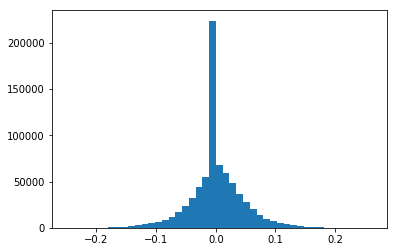

Pearson mean: 0.0021200601764949055, std: 0.043298070199947886


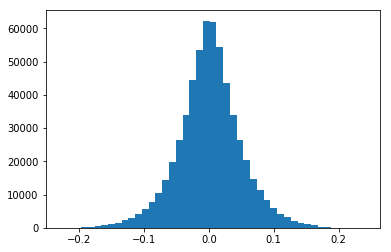

Spearman mean: 0.0015434449651629627, std: 0.04846799609562934


In [ ]:
corrs_pearson = [c.pearson for c in corrs if not math.isnan(c.pearson)]
corrs_spearman = [c.spearman for c in corrs if not math.isnan(c.spearman)]

plt.hist(corrs_pearson, bins=45)
plt.show()

print("Pearson mean: {}, std: {}".format(np.mean(corrs_pearson), np.std(corrs_pearson)))

plt.hist(corrs_spearman, bins=45)
plt.show()

print("Spearman mean: {}, std: {}".format(np.mean(corrs_spearman), np.std(corrs_spearman)))

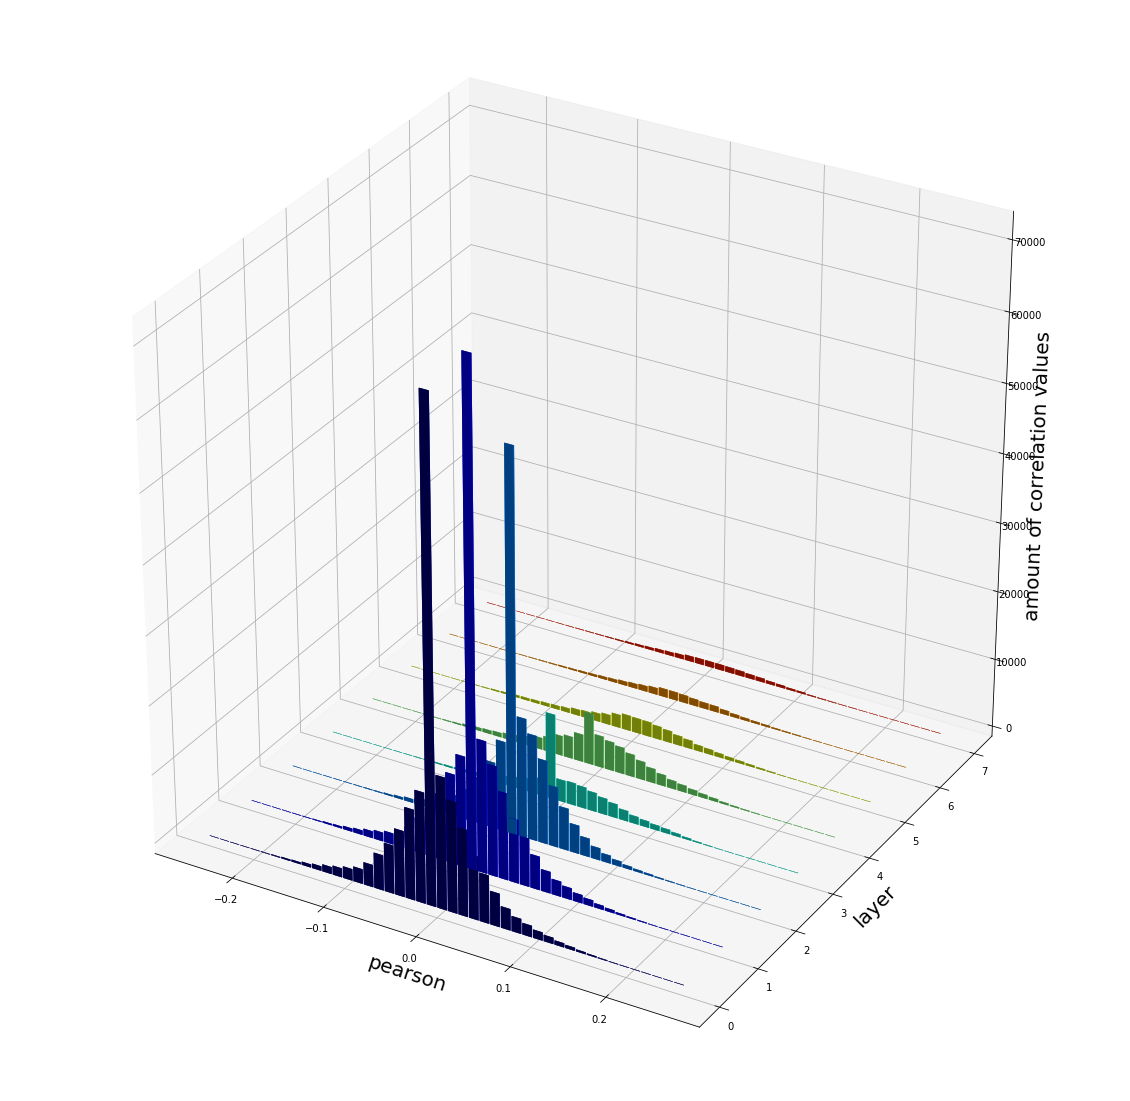

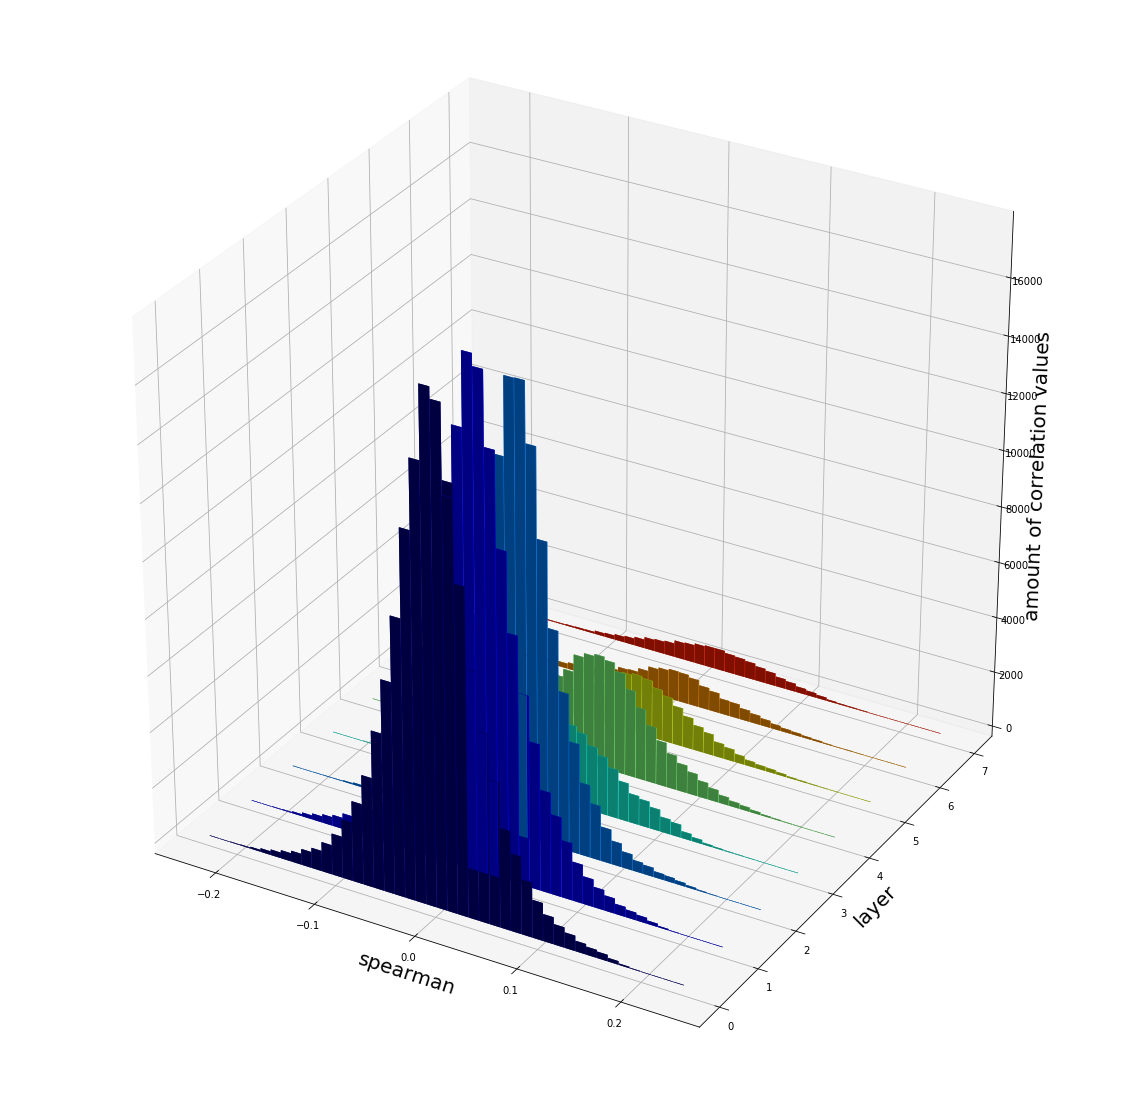

In [ ]:
h1 = Visualizer.hist3d(corrs, bins = 45, pearson = True)    
h2 = Visualizer.hist3d(corrs, bins = 45, pearson = False)

Utils.add_fig_to_image(h1)
Utils.add_fig_to_image(h2)
Utils.save_combined_image(Utils.get_path(["04_resnet", "results"], "3d_hist.png"), show_image = False,
                          combine_vertical = False)

# Analysis of each round

In [ ]:
start_round_frames = [630, 2900, 4580]
end_round_frames = [2120, 4370, 6050]

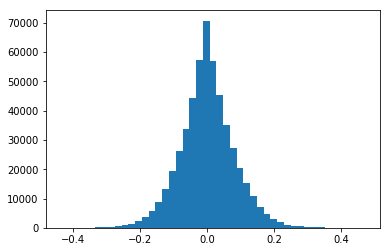

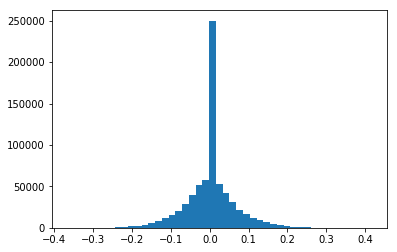

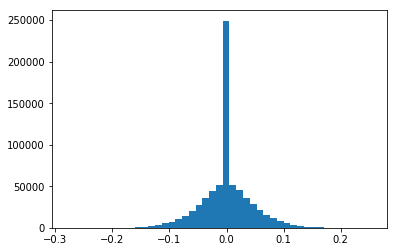

In [ ]:
corrs_round_1 = Correlation.correlate(activations, neuro_spikes, start_round_frames[0], end_round_frames[0],
                                      spearman = False)
corrs_round_2 = Correlation.correlate(activations, neuro_spikes, start_round_frames[1], end_round_frames[1],
                                      spearman = False)
corrs_round_3 = Correlation.correlate(activations, neuro_spikes, start_round_frames[2], end_round_frames[2],
                                      spearman = False)

corrs_round_1_without_nan = [c.pearson for c in corrs_round_1 if not math.isnan(c.pearson) and c.pearson != 0]
corrs_round_2_without_nan = [c.pearson for c in corrs_round_2 if not math.isnan(c.pearson) and c.pearson != 0]
corrs_round_3_without_nan = [c.pearson for c in corrs_round_3 if not math.isnan(c.pearson) and c.pearson != 0]

plt.hist(corrs_round_1_without_nan, bins=45)
plt.show()

plt.hist(corrs_round_2_without_nan, bins=45)
plt.show()

plt.hist(corrs_round_3_without_nan, bins=45)
plt.show()

In [ ]:
max_pearson_round_1 = max(corrs_round_1, key=attrgetter('pearson'))
max_pearson_round_2 = max(corrs_round_2, key=attrgetter('pearson'))
max_pearson_round_3 = max(corrs_round_3, key=attrgetter('pearson'))

print("layer {}, activation {}, row {}, column {}, pearson {}".format(max_pearson_round_1.layer,
                                                                      max_pearson_round_1.activation,
                                                                      max_pearson_round_1.row,
                                                                      max_pearson_round_1.column,
                                                                      max_pearson_round_1.pearson))
print("layer {}, activation {}, row {}, column {}, pearson {}".format(max_pearson_round_2.layer,
                                                                      max_pearson_round_2.activation,
                                                                      max_pearson_round_2.row,
                                                                      max_pearson_round_2.column,
                                                                      max_pearson_round_2.pearson))
print("layer {}, activation {}, row {}, column {}, pearson {}".format(max_pearson_round_3.layer,
                                                                      max_pearson_round_3.activation,
                                                                      max_pearson_round_3.row,
                                                                      max_pearson_round_3.column,
                                                                      max_pearson_round_3.pearson))

layer 0, activation 52, row 28, column 42, pearson 0.47194553488182306
layer 6, activation 205, row 3, column 4, pearson 0.416502321249168
layer 2, activation 27, row 34, column 35, pearson 0.25418800632068345


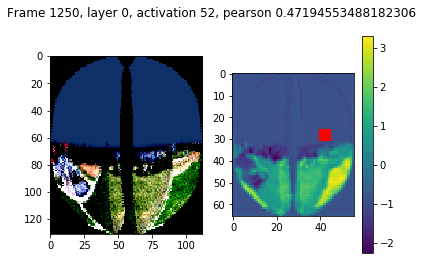

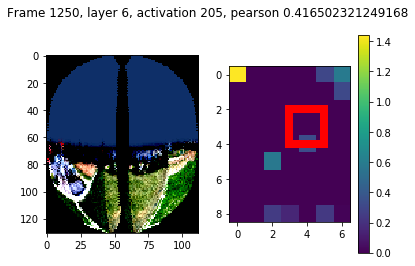

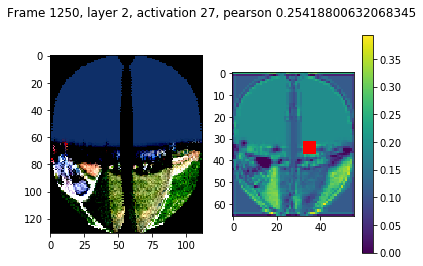

In [ ]:
f = Visualizer.show_correlation(max_pearson_round_1, 1250, data_flight_loader, model.children())
f = Visualizer.show_correlation(max_pearson_round_2, 1250, data_flight_loader, model.children())
f = Visualizer.show_correlation(max_pearson_round_3, 1250, data_flight_loader, model.children())

In [ ]:
path = Utils.get_path(["04_resnet", "results"], "pearson_round_1.jpg")

Visualizer.show_all_correlation(corrs_round_1, save_path = path)